In [29]:
import uproot
import numpy as np
import awkward as ak

@ak.mixin_class(ak.behavior)
class EcalRecHit:
    def layer(self):
        return (self.id >> 17) & 0x3f

def load_rec_hits(
    fp = None, *,
    include_header_params = False,
):
    """load ecal rec hits and event header into memory for analysis

    Parameters
    ----------
    fp : str, optional
        path to file(s) to load
        the default is to load all files that Tom generated and put in
        a specific directory in the shared group space
    include_header_params: bool, optional
        load the *Parameters from the EventHeader
        the code for doing this is kinda complicated so I want to keep it
        around but I don't think these are necessary for this study
    """
    
    if fp is None:
        fp = '/local/cms/user/eichl008/ldmx/dimuon-calibration/*.root'

    # load the data we want from the file into memory
    events = uproot.concatenate(
        fp+':LDMX_Events',
        filter_name = [ 'EventHeader**', 'EcalRecHits**' ]
    )

    # reformat the data into a more helpful form
    #  (basically just making shorter names and attaching helper functions)
    rec_hit_form = {
        m : events[f'EcalRecHits_dimuon.{m}_']
        for m in [
            'id', 'amplitude', 'energy', 'time', 'xpos','ypos','zpos','isNoise'
        ]
    }
    header_form = {
        name : events[branch]
        for name, branch in [
            ('number', 'eventNumber_'),
            ('run', 'run_'),
            ('weight', 'weight_')
        ]
    }
    header_form['EcalRecHits'] = ak.zip(rec_hit_form, with_name=EcalRecHit.__name__)
    if include_header_params:
        for param_type in ['float','int','string']:
            for key in np.unique(ak.flatten(events[f'{param_type}Parameters_.first']).to_numpy()):
                header_form[key] = ak.flatten(events[f'{param_type}Parameters_.second'][events[f'{param_type}Parameters_.first']==key])
    return ak.zip(header_form, depth_limit=1)

In [30]:
events = load_rec_hits()

In [33]:
tot_eot = ak.count(events.weight)/ak.sum(events.weight)*10*1e6
per_day = 1e12/tot_eot
num_events = ak.count(events.weight)
print(f'{num_events} in {tot_eot:.2e} EoT')
print(f'  which is ~{num_events*per_day:.0f} per day')

65508 in 8.63e+12 EoT
  which is ~7595 per day


In [35]:
import matplotlib as mpl
import mplhep
%matplotlib inline
mpl.style.use(mplhep.style.ROOT)
import matplotlib.pyplot as plt

import hist

In [40]:
xmax = 300
ymax = 300
hitmap = (
    hist.Hist.new
    .Reg(2*xmax,-xmax,xmax,label='x')
    .Reg(2*ymax,-ymax,ymax,label='y')
    .Double()
)

In [50]:
hits_in_first_layer = events.EcalRecHits[events.EcalRecHits.layer() == 0]
highest_energy_hit_in_first_layer = ak.drop_none(
    ak.firsts(
        hits_in_first_layer[ak.argsort(hits_in_first_layer.amplitude)]
    )
)

In [122]:
hitid = hist.Hist.new.IntCategory([],growth=True).Double()
hitid.fill(highest_energy_hit_in_first_layer.id)

def get_cell_center(id):
    hits_in_cell= highest_energy_hit_in_first_layer[highest_energy_hit_in_first_layer.id==id]
    return np.array([ak.mean(hits_in_cell.xpos), ak.mean(hits_in_cell.ypos)])
cell_center = np.array([get_cell_center(id) for id in hitid.axes[0]])

Text(0, 1, 'Y [mm]')

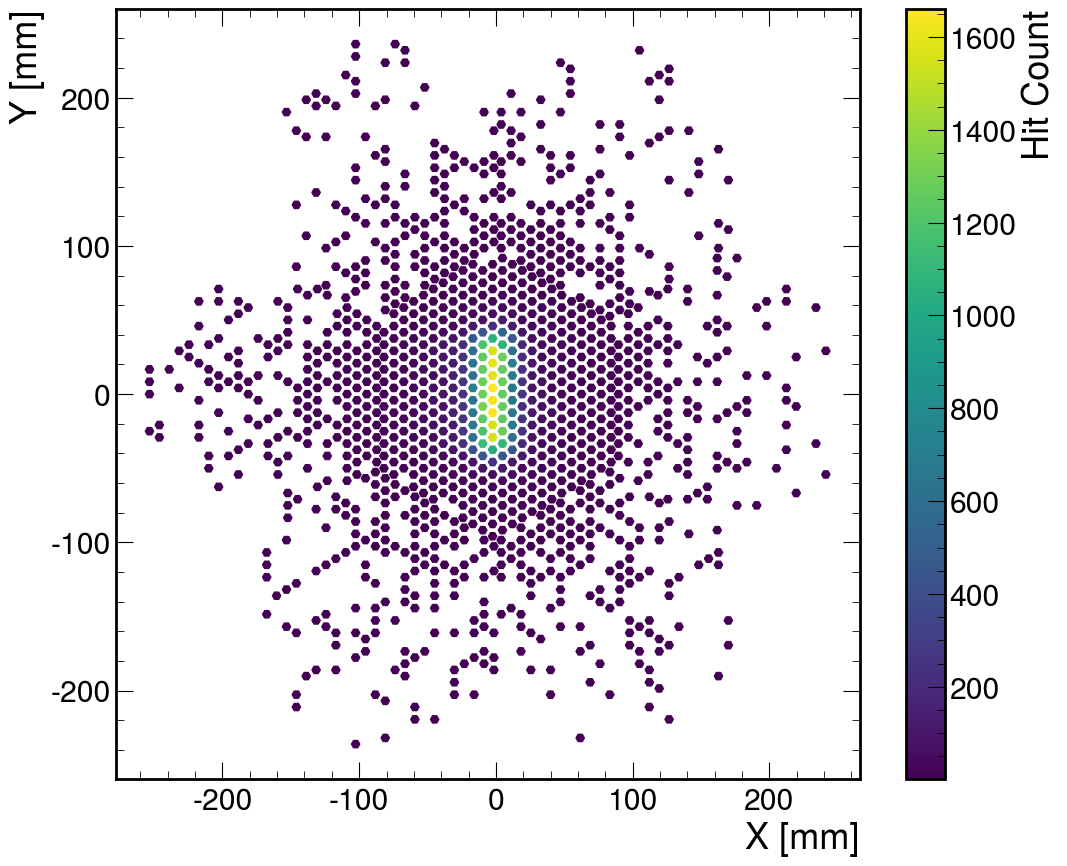

In [129]:
plt.figure(figsize=(12,10))
plt.scatter(
    cell_center[:,0], cell_center[:,1],
    c = hitid.values(),
    marker='H'
)
plt.colorbar(label='Hit Count')
plt.xlabel('X [mm]')
plt.ylabel('Y [mm]')